In [1]:
from models import *
import pandas as pd
import numpy as np
import tensorflow as tf
import shutil
import os
print("Tensorflow version: ", tf.__version__)

excel_reports = ".\Excel reports"
saved_models = ".\Saved models"
trained_models = ".\Trained models"

#Get Ticker and Period
ticker = 'clb'
period = "1wk"

# #Delete folders
shutil.rmtree(excel_reports)
shutil.rmtree(saved_models)
shutil.rmtree(trained_models)

#Create folder, if exist pass exception
try:
    os.mkdir("Excel reports")
    os.mkdir("Saved models")
    os.mkdir("Trained models")
except:
    pass


Tensorflow version:  2.9.1


In [2]:
news_df = pd.read_excel('sentiment_analysis.xlsx')
news_df = news_df.iloc[:,1:].copy()
news_df['Date'] = news_df['Date'].astype('datetime64[ns]')
news_df['Date'] = [x.strftime("%Y-%m-%d") for x in news_df['Date']]
news_df

c:\Users\z0040jeb\Desktop\MachineLearning\Data Science\VSCode\04_StockPrediction\04_stockprediction\lib\site-packages\pandas\core\dtypes\cast.py:1163: UserWarning: Parsing '17/09/2021' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  to_datetime(arr).values,
c:\Users\z0040jeb\Desktop\MachineLearning\Data Science\VSCode\04_StockPrediction\04_stockprediction\lib\site-packages\pandas\core\dtypes\cast.py:1163: UserWarning: Parsing '27/09/2021' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  to_datetime(arr).values,
c:\Users\z0040jeb\Desktop\MachineLearning\Data Science\VSCode\04_StockPrediction\04_stockprediction\lib\site-packages\pandas\core\dtypes\cast.py:1163: UserWarning: Parsing '18/10/2021' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  to_datetime(arr).values,
c:\Users\z0040jeb\Desktop\MachineLearning\Data Science\VSCode\04_St

,Date,Title,Content,APISentiment,VaderSentiment
0,2021-09-17,Core Laboratories N.V. (NYSE:CLB) Delivered A ...,While some investors are already well versed i...,0.991,0.4404
1,2021-09-27,Core Laboratories' Third Quarter 2021 Webcast ...,"AMSTERDAM, Sept. 27, 2021 /PRNewswire/ -- Core...",0.796,0.0000
2,2021-04-10,Hedge Funds Are Selling Great Western Bancorp ...,"At Insider Monkey, we pore over the filings of...",1.000,0.6249
3,2021-10-18,Why Core Laboratories Stock Is Sinking Today,Shares of Core Laboratories (NYSE: CLB) slid n...,0.296,0.0000
4,2021-10-20,Core Laboratories (CLB) Reports Next Week: Wal...,Core Laboratories (CLB) is expected to deliver...,0.998,0.3818
...,...,...,...,...,...
73,2022-01-08,Why Energy Stocks Dropped on Monday,Oil stocks had a rough start to the week after...,-0.772,0.2732
74,2022-05-08,SLB or CLB: Which Is the Better Value Stock Ri...,Investors looking for stocks in the Oil and Ga...,0.999,0.6486
75,2022-11-08,"Why Devon Energy, Tellurian, and Core Laborato...",Shares of oil and gas explorer Devon Energy (N...,0.942,0.2732
76,2022-08-22,SLB vs. CLB: Which Stock Should Value Investor...,Investors interested in Oil and Gas - Field Se...,0.997,0.3400


In [3]:
from transformers import PullData

#Initiate parameters
formation_window = 24
target_window = 4
sentiment = True
split_ratio = 0.80

if sentiment == False:
    news_df = None
    
#Do not change
window_size = formation_window + 1

#Print stuffs
print("window size: ",window_size)
print("formation_window: ",formation_window)
print("target_window: ",target_window)
print("chart period: ",period)

#training batches
batch_size_train = 8
batch_size_valid = 4

#Period model is trained and tested
start_date = '2020-01-01' #''2020-01-01   2015-01-01
end_date = '2022-09-04'  #'' 2022-08-17

GetData = PullData()

GetData.fit(ticker=ticker,
            start_date=start_date, 
            end_date=end_date, 
            interval=period, #1wk
            progress=False,
            condition=False,####################################
            form_window=formation_window,
            target_window=target_window,
            timeperiod1=6,
            timeperiod2=12,
            timeperiod3=24,
            export_excel=True,
            excel_path = excel_reports,
            listed_conditions = None,
            sentiment = sentiment,
            news_df=news_df)

data_prep = GetData.transform()

#Validation
if window_size != (formation_window + 1):
    raise Exception(f"Error - window_size ({window_size}) must be equal to sum of formation_window ({formation_window}) and value 1.")
data_prep.head()

window size:  25
formation_window:  24
target_window:  4
chart period:  1wk
initial shape:  (151, 6)
Output shape:  (2825, 10)
--------> PullData completed



,Date,Open,High,Low,Close,EMA6,EMA12,EMA24,APISentiment,trades
0,2019-12-30 00:00:00,39.400002,40.240002,36.500000,40.090000,37.968334,30.156667,23.542917,0.313667,1
1,2020-01-06 00:00:00,40.000000,41.610001,39.470001,40.230000,37.968334,30.156667,23.542917,0.997000,1
2,2020-01-13 00:00:00,40.380001,40.970001,39.369999,39.830002,37.968334,30.156667,23.542917,0.999000,1
3,2020-01-20 00:00:00,39.549999,39.980000,37.419998,37.869999,37.968334,30.156667,23.542917,0.999000,1
4,2020-01-27 00:00:00,36.810001,37.130001,34.599998,35.130001,37.968334,30.156667,23.542917,0.933333,1


In [4]:
####################################################################

from transformers import NormalizeData

NormalizeData = NormalizeData()

NormalizeData.fit(window_size=window_size, shuffle=False, debug=False,
                  export_excel=True, excel_path=excel_reports,sentiment=sentiment)

data_normalized, Dates = NormalizeData.transform(data_prep)
data_normalized.head()
# Get only forecasts for model testing
# x_valid_x = data_normalized[['maxv','minv']].copy() #extreme values for reverting normalization
# x_valid = data_normalized.iloc[:,:-2].copy() #dataset for forecast



Dataframe shape:  (2825, 10)
Number of formations:  113
--------> NormalizeData completed



,Open,High,Low,Close,EMA6,EMA12,EMA24,APISentiment,maxv,minv
0,0.936731,0.960779,0.853707,0.956484,0.895744,0.672106,0.482763,0.313667,41.610001,6.68
1,0.953908,1.000000,0.938735,0.960492,0.895744,0.672106,0.482763,0.997000,41.610001,6.68
2,0.964787,0.981678,0.935872,0.949041,0.895744,0.672106,0.482763,0.999000,41.610001,6.68
3,0.941025,0.953335,0.880046,0.892929,0.895744,0.672106,0.482763,0.999000,41.610001,6.68
4,0.862582,0.871744,0.799313,0.814486,0.895744,0.672106,0.482763,0.933333,41.610001,6.68


In [5]:
####################################################################

from training import SplitData

SplitData = SplitData()

SplitData.fit(split_ratio=split_ratio, window_size=window_size,
              dates=Dates, debug=False, export_excel=True, excel_path=excel_reports,sentiment=sentiment)

x_train, x_valid, x_train_x, x_valid_x = SplitData.transform(data_normalized)
#x_train.head(25)



Split ratio: 80 %
train period: 2019-12-30 - 2022-02-21
valid period: 2021-09-20 - 2022-08-01
x_train window:  90.0
x_valid window:  23.0
--------> SplitData completed



In [6]:
from training import GetTensoredDataset

GetTensoredDataset = GetTensoredDataset()

GetTensoredDataset.fit(window_size=window_size, batch_size=batch_size_train, train=True, debug=False)

x_train_tensors, _ = GetTensoredDataset.transform(x_train)

# c = 0
# for batch in x_train_tensors:
#     if c < 3:
#         print(batch)
#     else:
#         break

--------> GetTensoredDataset completed



In [7]:
from training import GetTensoredDataset

GetTensoredValidDataset = GetTensoredDataset()

GetTensoredValidDataset.fit(
    window_size=window_size, batch_size=batch_size_valid, train=False, debug=False)

x_valid_tensors, labels = GetTensoredValidDataset.transform(x_valid)

# for batch in x_valid_tensors:
#     if c < 3:
#         print(batch)
#     else:
#         break

--------> GetTensoredDataset completed



<b>Model Training</b>

In [8]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint


model_name = f'{saved_models}/{str.upper(ticker)}_{formation_window}_{target_window}_{window_size}_{split_ratio}_{period}_{sentiment}_{start_date}_{end_date}.h5'

early_stopping = EarlyStopping(
    monitor='val_loss', patience=6, mode='min', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=10e-15,
                              verbose=1)

model_checkpoint = ModelCheckpoint(monitor='val_loss',
                                   filepath=model_name,
                                   save_best_only=True)

callbacks = [early_stopping, reduce_lr, model_checkpoint]


def sign_penalty(y_true, y_pred):
    penalty = 100.
    loss = tf.where(tf.less(y_true*y_pred, 0),
                    penalty * tf.square(y_true-y_pred),
                    tf.square(y_true - y_pred)
                    )

    return(tf.reduce_mean(loss, axis=-1))


tf.keras.losses.sign_penalty = sign_penalty


Get Model

In [9]:
tf.random.set_seed(7788)
np.random.seed(7788)

input_shape = x_train.shape[1]
print(f"Model training - {str.upper(ticker)} \n")

model = clb_model(input_shape)


# model = tf.keras.models.Sequential([

#         tf.keras.layers.Conv1D(filters=8, kernel_size=1,
#                                strides=1, padding="same",
#                                activation=tf.nn.selu,
#                                input_shape=[None, input_shape]),
#         tf.keras.layers.Conv1D(filters=16, kernel_size=1,
#                                strides=1, padding="same",
#                                activation=tf.nn.selu,
#                                #input_shape=[None, 7]
#                                ),
#         tf.keras.layers.Conv1D(filters=32, kernel_size=10,
#                                strides=1, padding="same",
#                                activation=tf.nn.selu,
#                                #input_shape=[None, 7]
#                                ),

#         tf.keras.layers.Bidirectional(
#             tf.keras.layers.LSTM(9, return_sequences=True)),
#         tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(9)),

#         tf.keras.layers.Dense(3, activation=tf.nn.selu),
#         tf.keras.layers.Dense(3, activation=tf.nn.selu),
#         tf.keras.layers.Dense(3, activation=tf.nn.selu),
#         tf.keras.layers.Dense(3, activation=tf.nn.relu),
#         tf.keras.layers.Dense(3, activation=tf.nn.selu),
#         tf.keras.layers.Dense(3, activation=tf.nn.selu),
#         tf.keras.layers.Dense(2, activation=tf.nn.selu),
#         tf.keras.layers.Dense(1, activation=tf.nn.relu),
#     ])

optimizer2 = tf.keras.optimizers.Adam(
    learning_rate=0.0009, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)
optimizer5 = tf.keras.optimizers.Adagrad(
    learning_rate=0.005, initial_accumulator_value=8, epsilon=1e-07, name='Adagrad')

model.compile(loss=sign_penalty,
              optimizer=optimizer5,
              )

model.fit(x_train_tensors, epochs=1200, callbacks=[
          callbacks], validation_data=x_valid_tensors)


Model training - CLB 

Epoch 1/1200
12/12 [==============================] - 10s 328ms/step - loss: 0.2047 - val_loss: 0.0932 - lr: 0.0050
Epoch 2/1200
12/12 [==============================] - 0s 29ms/step - loss: 0.1321 - val_loss: 0.0760 - lr: 0.0050
Epoch 3/1200
12/12 [==============================] - 0s 36ms/step - loss: 0.1071 - val_loss: 0.0724 - lr: 0.0050
Epoch 4/1200
12/12 [==============================] - 0s 26ms/step - loss: 0.0968 - val_loss: 0.0726 - lr: 0.0050
Epoch 5/1200
10/12 [========================>.....] - ETA: 0s - loss: 0.0969
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
12/12 [==============================] - 0s 24ms/step - loss: 0.0922 - val_loss: 0.0738 - lr: 0.0050
Epoch 6/1200
12/12 [==============================] - 0s 22ms/step - loss: 0.0891 - val_loss: 0.0741 - lr: 1.0000e-03
Epoch 7/1200
12/12 [==============================] - ETA: 0s - loss: 0.0887
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.000199999986216

In [10]:
# model_name = f'{saved_models}/{str.upper(ticker)}_{formation_window}_{target_window}_{window_size}_{split_ratio}_{period}_{start_date}_{end_date}.h5'
# model_name = 'Saved models\STNE_24_4_25_0.8_2020-01-01_2022-08-17.h5'
# model = tf.keras.models.load_model(model_name, custom_objects={
#                                              'sign_penalty': sign_penalty})


In [11]:
def model_forecast(model, series, window_size, debug):
    """
    Get model, data and window size as an input. 
    Make prediction window is subtracted by 1, since we do not need label in window, 
    label value is skipped
    """
    c = 0

    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size-1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))

    if debug == True:
        # This block of code will print out data on which is made prediction
        for item in ds:
            c += 1
            if c < 3:
                print("\n"+str(c) + " prediction:\n ", item)
            else:
                break

    ds = ds.batch(1).prefetch(1)
    forecast = model.predict(ds)
    forecast2 = np.squeeze(forecast)
    return forecast2


forecast = model_forecast(model, x_valid, window_size=window_size, debug=False)
forecast[:2]


23/23 [==============================] - 2s 7ms/step


array([0.5734575 , 0.58104914], dtype=float32)

In [12]:
# pr = x_valid.iloc[:24, :].to_numpy()
# pr = np.array([pr])
# pr = np.array([pr])
# pred = tf.data.Dataset.from_tensor_slices(pr)

In [13]:
from transformers import ReverseNormalization

ReverseNormalization = ReverseNormalization()

ReverseNormalization.fit(forecasts=forecast, labels=labels,
                         x_valid=x_valid, x_valid_x=x_valid_x, window_size=window_size, debug=False,sentiment=sentiment)

df = ReverseNormalization.transform()
df.head(25)

--------> ReverseNormalization completed



,Open,High,Low,Close,EMA6,EMA12,EMA24,labels,prediction,APISentiment
In,,,,,,,,,,
0,26.270000,28.070000,26.030001,27.190001,28.113060,29.974975,31.471292,NaN,NaN,0.796000
1,28.000000,30.430000,26.580000,29.049999,28.380757,29.832671,31.277589,NaN,NaN,0.796000
2,29.730000,30.430000,27.219999,30.290001,28.926255,29.903030,31.198582,NaN,NaN,0.990000
3,30.830000,32.220001,29.420000,31.540001,29.673040,30.154871,31.225895,NaN,NaN,0.996500
4,30.190001,31.320000,28.000000,28.230000,29.260742,29.858737,30.986224,NaN,NaN,0.647000
5,28.500000,28.750000,24.410000,26.010000,28.331959,29.266624,30.588126,NaN,NaN,0.849714
6,26.219999,27.870001,25.690001,27.709999,28.154256,29.027143,30.357876,NaN,NaN,0.942000
7,28.120001,28.920000,26.000000,26.129999,27.575897,28.581429,30.019646,NaN,NaN,0.942000
8,26.070000,27.420000,23.870001,24.379999,26.662783,27.935055,29.568474,NaN,NaN,0.998000


In [14]:
from final_evaluation import GetFinalDataframe

GetFinalDataframe = GetFinalDataframe()

GetFinalDataframe.fit(dates=Dates,
                      x_valid=x_valid,
                      sentiment=sentiment)

reversed_df = GetFinalDataframe.transform(df)
reversed_df.head(25)


--------> GetFinalDataframe



,Open,High,Low,Close,EMA6,EMA12,EMA24,labels,prediction,APISentiment,Datetime
In,,,,,,,,,,,
0,26.270000,28.070000,26.030001,27.190001,28.113060,29.974975,31.471292,nn,nn,0.796000,2021-09-20
1,28.000000,30.430000,26.580000,29.049999,28.380757,29.832671,31.277589,nn,nn,0.796000,2021-09-27
2,29.730000,30.430000,27.219999,30.290001,28.926255,29.903030,31.198582,nn,nn,0.990000,2021-10-04
3,30.830000,32.220001,29.420000,31.540001,29.673040,30.154871,31.225895,nn,nn,0.996500,2021-10-11
4,30.190001,31.320000,28.000000,28.230000,29.260742,29.858737,30.986224,nn,nn,0.647000,2021-10-18
5,28.500000,28.750000,24.410000,26.010000,28.331959,29.266624,30.588126,nn,nn,0.849714,2021-10-25
6,26.219999,27.870001,25.690001,27.709999,28.154256,29.027143,30.357876,nn,nn,0.942000,2021-11-01
7,28.120001,28.920000,26.000000,26.129999,27.575897,28.581429,30.019646,nn,nn,0.942000,2021-11-08
8,26.070000,27.420000,23.870001,24.379999,26.662783,27.935055,29.568474,nn,nn,0.998000,2021-11-15


In [15]:
from final_evaluation import GetModelPerformance
#print(f"Window size: {window_size} \n")
print(f"ticker: {str.upper(ticker)}\n")
GetModelPerformance = GetModelPerformance()

GetModelPerformance.fit(acceptance=0,
                        penalization=0,
                        entry_candle='Current Open',
                        budget=10000,
                        window_size=window_size,
                        export_excel=True,
                        excel_path = excel_reports,
                        sentiment=sentiment)

trades_df = GetModelPerformance.transform(reversed_df)
trades_df.head(25)


ticker: CLB

Formations:  23
period: 2021-09-20 - 2022-08-01
Entry Candle:  Current Open

Total Trades:  16
Profit Trades:  8
Loss Trades:  8

Win Ratio: 50.0 %
Loss Ratio: 50 %

Trade nr with exact TP:  5
Ratio of exact TP: 31.0 %

Average profit per trade:  436

Gross profit:  6976
Gross loss:  -10054

Net profit:  -3078


,Open,High,Low,Close,EMA6,EMA12,EMA24,labels,prediction,APISentiment,Datetime,profit,trade
In,,,,,,,,,,,,,
0,26.270000,28.070000,26.030001,27.190001,28.113060,29.974975,31.471292,nn,nn,0.796000,2021-09-20,2.118499,1
1,28.000000,30.430000,26.580000,29.049999,28.380757,29.832671,31.277589,nn,nn,0.796000,2021-09-27,2.118499,1
2,29.730000,30.430000,27.219999,30.290001,28.926255,29.903030,31.198582,nn,nn,0.990000,2021-10-04,2.118499,1
3,30.830000,32.220001,29.420000,31.540001,29.673040,30.154871,31.225895,nn,nn,0.996500,2021-10-11,2.118499,1
4,30.190001,31.320000,28.000000,28.230000,29.260742,29.858737,30.986224,nn,nn,0.647000,2021-10-18,2.118499,1
5,28.500000,28.750000,24.410000,26.010000,28.331959,29.266624,30.588126,nn,nn,0.849714,2021-10-25,2.118499,1
6,26.219999,27.870001,25.690001,27.709999,28.154256,29.027143,30.357876,nn,nn,0.942000,2021-11-01,2.118499,1
7,28.120001,28.920000,26.000000,26.129999,27.575897,28.581429,30.019646,nn,nn,0.942000,2021-11-08,2.118499,1
8,26.070000,27.420000,23.870001,24.379999,26.662783,27.935055,29.568474,nn,nn,0.998000,2021-11-15,2.118499,1


In [16]:
trade = 1
budget = 10000
entry_candle = 'Current Open'
# loss = trades_df[trades_df['profit']<0]
# loss['trade'].unique()
# trades_df.loc[trades_df['trade']==12]
trades_df

,Open,High,Low,Close,EMA6,EMA12,EMA24,labels,prediction,APISentiment,Datetime,profit,trade
In,,,,,,,,,,,,,
0,26.270000,28.070000,26.030001,27.190001,28.113060,29.974975,31.471292,nn,nn,0.796000,2021-09-20,2.118499,1
1,28.000000,30.430000,26.580000,29.049999,28.380757,29.832671,31.277589,nn,nn,0.796000,2021-09-27,2.118499,1
2,29.730000,30.430000,27.219999,30.290001,28.926255,29.903030,31.198582,nn,nn,0.990000,2021-10-04,2.118499,1
3,30.830000,32.220001,29.420000,31.540001,29.673040,30.154871,31.225895,nn,nn,0.996500,2021-10-11,2.118499,1
4,30.190001,31.320000,28.000000,28.230000,29.260742,29.858737,30.986224,nn,nn,0.647000,2021-10-18,2.118499,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
570,18.190001,18.549999,15.210000,15.880000,19.801003,22.442774,24.738753,nn,nn,0.661333,2022-07-11,0.530001,16
571,16.469999,17.770000,16.360001,17.309999,19.089287,21.653116,24.144453,nn,nn,0.661333,2022-07-18,0.530001,16
572,17.559999,19.420000,17.090000,18.940001,19.046634,21.235714,23.728097,nn,nn,0.113167,2022-07-25,0.530001,16


Trade:  1
Window size:  25
Period: 2021-09-20 - 2022-02-28

Budget:  10000

Entry price:  27.42
Label (target):  35.83
Model prediction:  29.54
Market Change: 2.12 $
Profit: 773.16 $


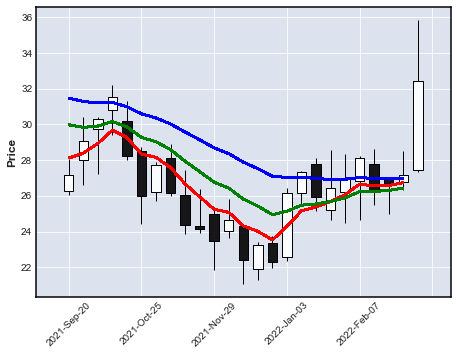

,Open,High,Low,Close,EMA6,EMA12,EMA24,labels,prediction,APISentiment,Datetime,profit,trade
In,,,,,,,,,,,,,
0,26.270000,28.070000,26.030001,27.190001,28.113060,29.974975,31.471292,nn,nn,0.796000,2021-09-20,2.118499,1
1,28.000000,30.430000,26.580000,29.049999,28.380757,29.832671,31.277589,nn,nn,0.796000,2021-09-27,2.118499,1
2,29.730000,30.430000,27.219999,30.290001,28.926255,29.903030,31.198582,nn,nn,0.990000,2021-10-04,2.118499,1
3,30.830000,32.220001,29.420000,31.540001,29.673040,30.154871,31.225895,nn,nn,0.996500,2021-10-11,2.118499,1
4,30.190001,31.320000,28.000000,28.230000,29.260742,29.858737,30.986224,nn,nn,0.647000,2021-10-18,2.118499,1
5,28.500000,28.750000,24.410000,26.010000,28.331959,29.266624,30.588126,nn,nn,0.849714,2021-10-25,2.118499,1
6,26.219999,27.870001,25.690001,27.709999,28.154256,29.027143,30.357876,nn,nn,0.942000,2021-11-01,2.118499,1
7,28.120001,28.920000,26.000000,26.129999,27.575897,28.581429,30.019646,nn,nn,0.942000,2021-11-08,2.118499,1
8,26.070000,27.420000,23.870001,24.379999,26.662783,27.935055,29.568474,nn,nn,0.998000,2021-11-15,2.118499,1


In [18]:
trade = 1
from plotting import PlotTrade

df = PlotTrade(trade=trade,trades_df=trades_df,window_size=window_size,entry_candle=entry_candle,budget=budget,sentiment=sentiment)
trade += 1
df


In [19]:
from final_evaluation import GetPerformanceReport

GetPerformanceReport = GetPerformanceReport()

GetPerformanceReport.fit(entry_candle="Current Open",
                        budget=10000,
                        window_size=window_size,
                        export_excel=True,
                        excel_path = excel_reports)

trades_df_final = GetPerformanceReport.transform(trades_df)
trades_df_final


--------> GetPerformanceReport completed



,Open,High,Low,Close,EMA6,EMA12,EMA24,labels,prediction,APISentiment,Datetime,profit,trade,Entry,Performance
0,26.270000,28.070000,26.030001,27.190001,28.113060,29.974975,31.471292,nn,nn,0.796000,2021-09-20,2.118499,1,nn,nn
1,28.000000,30.430000,26.580000,29.049999,28.380757,29.832671,31.277589,nn,nn,0.796000,2021-09-27,2.118499,1,nn,nn
2,29.730000,30.430000,27.219999,30.290001,28.926255,29.903030,31.198582,nn,nn,0.990000,2021-10-04,2.118499,1,nn,nn
3,30.830000,32.220001,29.420000,31.540001,29.673040,30.154871,31.225895,nn,nn,0.996500,2021-10-11,2.118499,1,nn,nn
4,30.190001,31.320000,28.000000,28.230000,29.260742,29.858737,30.986224,nn,nn,0.647000,2021-10-18,2.118499,1,nn,nn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,18.190001,18.549999,15.210000,15.880000,19.801003,22.442774,24.738753,nn,nn,0.661333,2022-07-11,0.530001,16,nn,nn
396,16.469999,17.770000,16.360001,17.309999,19.089287,21.653116,24.144453,nn,nn,0.661333,2022-07-18,0.530001,16,nn,nn
397,17.559999,19.420000,17.090000,18.940001,19.046634,21.235714,23.728097,nn,nn,0.113167,2022-07-25,0.530001,16,nn,nn
398,18.379999,19.020000,16.110001,16.350000,18.276167,20.484065,23.137849,nn,nn,0.992000,2022-08-01,0.530001,16,nn,nn


In [20]:
from final_evaluation import MakeSinglePrediction

model_name = f'{saved_models}/{str.upper(ticker)}_{formation_window}_{target_window}_{window_size}_{split_ratio}_{period}_{sentiment}_{start_date}_{end_date}.h5'

MakeSinglePrediction = MakeSinglePrediction()

fit_output = MakeSinglePrediction.fit(
                        model_name=model_name,
                        form_window=formation_window,
                        ticker=ticker,
                        start_date="2021-03-18",
                        end_date="2022-09-04",
                        interval='1wk',
                        progress=False,
                        condition=False,
                        timeperiod1=6,
                        timeperiod2=12,
                        timeperiod3=24,
                        debug=False,
                        budget=10000,
                        penalization=0,
                        acceptance=0,
                        entry_candle='Current Close',
                        news_df=news_df,
                        sentiment=sentiment)

#fit method outputs tuple, get only trade formation out of tuple
trade_formation = fit_output[1]
final_trade_formation = trade_formation.tail(24)
final_trade_formation
###IMPORTANT!!!!
#trade_formation dataframe must be checked before transformation, sometimes df pulled via yahoo finance 
# is shifted, and trade formation does not have entire formation in itself. in this case there must 
# be changed end_date in fit method
#final_trade_formation.fillna(0,inplace=True)
final_trade_formation


,Date,Open,High,Low,Close,EMA6,EMA12,EMA24,APISentiment
1,2022-03-21,29.500000,32.160000,28.750000,31.980000,29.431842,28.206194,27.920627,0.991333
2,2022-03-28,31.299999,32.900002,29.620001,32.430000,30.288459,28.856011,28.281377,0.839857
3,2022-04-04,32.660000,34.080002,30.639999,33.619999,31.240327,29.588932,28.708467,1.000000
4,2022-04-11,33.360001,34.060001,31.290001,33.610001,31.917377,30.207558,29.100590,0.000000
5,2022-04-18,32.660000,34.020000,28.730000,29.170000,31.132412,30.047934,29.106143,0.998000
6,2022-04-25,28.330000,28.330000,24.760000,26.000000,29.666009,29.425175,28.857651,0.784429
7,2022-05-02,25.780001,27.540001,24.620001,27.469999,29.038577,29.124378,28.746639,0.854500
8,2022-05-09,26.740000,26.740000,21.809999,23.360001,27.416127,28.237551,28.315708,0.000000
9,2022-05-16,23.549999,25.250000,23.549999,24.520000,26.588662,27.665620,28.012051,0.000000
10,2022-05-23,24.840000,28.049999,24.480000,27.580000,26.871902,27.652448,27.977487,0.996000


In [21]:
#Make prediction
MakeSinglePrediction.transform(final_trade_formation)

#PLot current chart
# from plotting import PlotCurrentFormation
# PlotCurrentFormation(final_trade_formation)
# #18.75


Ticker:  clb
1/1 [==============================] - 2s 2s/step

Entry candle (Current Close)

Budget:  10000

Entry price:  16.93
Prediction:  24.91
Expected Market move:  7.98
Expected Profit:  4714.66


In [ ]:
#18.08 no sentiment
#19.11 no sentiment reshuffled

<b>Record Predictions</b>

In [25]:
final_df = pd.DataFrame()
#List all predictions
dicti_prediction1 = {'ticker':['STNSE'],'Date':['21.8.2022'],'prediction':['12.97 (should be penalized by 2 - 10.97)'],'real market move':['pending']}
dicti_prediction2 = {'ticker':['CLB'],'Date':['21.8.2022'],'prediction':['18.6'],'real market move':['pending']}
dicti_prediction3 = {'ticker':['MRK'],'Date':['27.8.2022'],'prediction':['93.23'],'real market move':['pending']}
dicti_prediction4 = {'ticker':['CLB'],'Date':['04.9.2022'],'prediction':['18.08'],'real market move':['pending']}

trades_tuple = (dicti_prediction1,dicti_prediction2,dicti_prediction3,dicti_prediction4)
for item in trades_tuple:
    df_pred = pd.DataFrame(item)
    final_df = final_df.append(df_pred)
final_df

,ticker,Date,prediction,real market move
0,STNSE,21.8.2022,12.97 (should be penalized by 2 - 10.97),pending
0,CLB,21.8.2022,18.6,pending
0,MRK,27.8.2022,93.23,pending
0,CLB,04.9.2022,18.08,pending


<b>Sentiment Analysis</b>

In [106]:
import requests
#from termcolor import colored as cl
api_key = '631505e804ec58.42743136'

In [107]:
def get_customized_news(stock, start_date, end_date, n_news, api_key, offset = 0):
    url = f'https://eodhistoricaldata.com/api/news?api_token={api_key}&s={stock}&limit={n_news}&offset={offset}&from={start_date}&to={end_date}'
    news_json = requests.get(url).json()
    
    news = []
    
    for i in range(len(news_json)):
        title = news_json[-i]['title']
        news.append(title)
        #print(cl('{}. '.format(i+1), attrs = ['bold']), '{}'.format(title))
    
    return news,news_json

clb_news,json = get_customized_news('clb', '2021-09-01', '2022-09-04', 100, api_key, 0)
json

[{'date': '2022-08-24T10:20:39+00:00',
  'title': "Should You Be Concerned About Core Laboratories N.V.'s (NYSE:CLB) ROE?",
  'content': "Many investors are still learning about the various metrics that can be useful when analysing a stock. This article is for those who would like to learn about Return On Equity (ROE). To keep the lesson grounded in practicality, we'll use ROE to better understand Core Laboratories N.V. (NYSE:CLB).\n\nReturn on Equity or ROE is a test of how effectively a company is growing its value and managing investors’ money. Put another way, it reveals the company's success at turning shareholder investments into profits.\n\nSee our latest analysis for Core Laboratories\n\nHow Is ROE Calculated?\n\nThe formula for ROE is:\n\nReturn on Equity = Net Profit (from continuing operations) ÷ Shareholders' Equity\n\nSo, based on the above formula, the ROE for Core Laboratories is:\n\n5.2% = US$9.1m ÷ US$174m (Based on the trailing twelve months to June 2022).\n\nThe 'ret

In [66]:
# import json
  
# # Opening JSON file
# f = open('json.json')
  
# # returns JSON object as 
# # a dictionary
# data = json.load(f)
# for i in data:
#     print(i)
#json

In [125]:
import pandas as pd
news_df = pd.DataFrame()

for item in json:
    #extract data
    date = item['date']
    title = item['title'] 
    content = item['content']
    sentiment = item['sentiment']['polarity']
    dicti = {'Date':[date],'Title':[title],'Content':[content],'APISentiment':[sentiment]}
    #append to dataframe
    temp_df = pd.DataFrame(dicti)
    news_df = pd.concat([temp_df,news_df],axis=0)

news_df['Date'] = news_df['Date'].astype('datetime64[ns]')
news_df['Date'] = [x.strftime("%Y-%m-%d") for x in news_df['Date']]
#news_df

In [126]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.downloader.download('vader_lexicon')

news_df['VaderSentiment'] = 0
vader = SentimentIntensityAnalyzer()

for row in range(news_df.shape[0]):
    title = news_df.iloc[row,1]
    title = f'"{title}"'
    content = news_df.iloc[row,2] 
    #print(title)
    score = vader.polarity_scores(title)
    compound_score = score['compound']
    # print(score)
    # print(compound_score)
    news_df.iloc[row,4] = compound_score
    
news_df

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\z0040jeb\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,Date,Title,Content,APISentiment,VaderSentiment
0,2021-09-17,Core Laboratories N.V. (NYSE:CLB) Delivered A ...,While some investors are already well versed i...,0.991,0.4404
0,2021-09-27,Core Laboratories' Third Quarter 2021 Webcast ...,"AMSTERDAM, Sept. 27, 2021 /PRNewswire/ -- Core...",0.796,0.0000
0,2021-10-04,Hedge Funds Are Selling Great Western Bancorp ...,"At Insider Monkey, we pore over the filings of...",1.000,0.6249
0,2021-10-18,Why Core Laboratories Stock Is Sinking Today,Shares of Core Laboratories (NYSE: CLB) slid n...,0.296,0.0000
0,2021-10-20,Core Laboratories (CLB) Reports Next Week: Wal...,Core Laboratories (CLB) is expected to deliver...,0.998,0.3818
...,...,...,...,...,...
0,2022-08-01,Why Energy Stocks Dropped on Monday,Oil stocks had a rough start to the week after...,-0.772,0.2732
0,2022-08-05,SLB or CLB: Which Is the Better Value Stock Ri...,Investors looking for stocks in the Oil and Ga...,0.999,0.6486
0,2022-08-11,"Why Devon Energy, Tellurian, and Core Laborato...",Shares of oil and gas explorer Devon Energy (N...,0.942,0.2732
0,2022-08-22,SLB vs. CLB: Which Stock Should Value Investor...,Investors interested in Oil and Gas - Field Se...,0.997,0.3400


In [117]:
news_df.to_excel('sentiment_analysis.xlsx')

In [8]:
news_df.iloc[:,:]

NameError: name 'news_df' is not defined

In [3]:
news_df = pd.read_excel('sentiment_analysis.xlsx')
news_df = news_df.iloc[:,1:].copy()
news_df['Date'] = news_df['Date'].astype('datetime64[ns]')
news_df['Date'] = [x.strftime("%Y-%m-%d") for x in news_df['Date']]
news_df

,Date,Title,Content,APISentiment,VaderSentiment
0,2021-09-17,Core Laboratories N.V. (NYSE:CLB) Delivered A ...,While some investors are already well versed i...,0.991,0.4404
1,2021-09-27,Core Laboratories' Third Quarter 2021 Webcast ...,"AMSTERDAM, Sept. 27, 2021 /PRNewswire/ -- Core...",0.796,0.0000
2,2021-04-10,Hedge Funds Are Selling Great Western Bancorp ...,"At Insider Monkey, we pore over the filings of...",1.000,0.6249
3,2021-10-18,Why Core Laboratories Stock Is Sinking Today,Shares of Core Laboratories (NYSE: CLB) slid n...,0.296,0.0000
4,2021-10-20,Core Laboratories (CLB) Reports Next Week: Wal...,Core Laboratories (CLB) is expected to deliver...,0.998,0.3818
...,...,...,...,...,...
73,2022-01-08,Why Energy Stocks Dropped on Monday,Oil stocks had a rough start to the week after...,-0.772,0.2732
74,2022-05-08,SLB or CLB: Which Is the Better Value Stock Ri...,Investors looking for stocks in the Oil and Ga...,0.999,0.6486
75,2022-11-08,"Why Devon Energy, Tellurian, and Core Laborato...",Shares of oil and gas explorer Devon Energy (N...,0.942,0.2732
76,2022-08-22,SLB vs. CLB: Which Stock Should Value Investor...,Investors interested in Oil and Gas - Field Se...,0.997,0.3400


In [30]:
#news_df['Week'] = 0

#news_df
news_df['Date'] = news_df['Date'].astype('datetime64[ns]')
news_df['Week'] = news_df['Date'].apply(lambda x: x.week)
news_df.dtypes
news_df

,Date,Title,Content,APISentiment,VaderSentiment,Week
0,2021-09-17,Core Laboratories N.V. (NYSE:CLB) Delivered A ...,While some investors are already well versed i...,0.991,0.4404,37
1,2021-09-27,Core Laboratories' Third Quarter 2021 Webcast ...,"AMSTERDAM, Sept. 27, 2021 /PRNewswire/ -- Core...",0.796,0.0000,39
2,2021-04-10,Hedge Funds Are Selling Great Western Bancorp ...,"At Insider Monkey, we pore over the filings of...",1.000,0.6249,14
3,2021-10-18,Why Core Laboratories Stock Is Sinking Today,Shares of Core Laboratories (NYSE: CLB) slid n...,0.296,0.0000,42
4,2021-10-20,Core Laboratories (CLB) Reports Next Week: Wal...,Core Laboratories (CLB) is expected to deliver...,0.998,0.3818,42
...,...,...,...,...,...,...
73,2022-01-08,Why Energy Stocks Dropped on Monday,Oil stocks had a rough start to the week after...,-0.772,0.2732,1
74,2022-05-08,SLB or CLB: Which Is the Better Value Stock Ri...,Investors looking for stocks in the Oil and Ga...,0.999,0.6486,18
75,2022-11-08,"Why Devon Energy, Tellurian, and Core Laborato...",Shares of oil and gas explorer Devon Energy (N...,0.942,0.2732,45
76,2022-08-22,SLB vs. CLB: Which Stock Should Value Investor...,Investors interested in Oil and Gas - Field Se...,0.997,0.3400,34


In [77]:
news_df_agg = news_df.groupby('Week')['APISentiment'].mean()
news_df_agg.head()

Week
1     0.313667
2     0.997000
4     0.999000
5     0.933333
11    0.989200
Name: APISentiment, dtype: float64

In [ ]:
data_prep.dtypes
ddd = data_prep.head(10).copy()

In [78]:
ddd['Week'] = 0
ddd['Date'] = ddd['Date'].astype('datetime64[ns]')
ddd['Date'] = [x.strftime("%Y-%m-%d") for x in ddd['Date']]
ddd['Date'] = ddd['Date'].astype('datetime64[ns]')
ddd['Week'] = ddd['Date'].apply(lambda x: x.week)
ddd.dtypes

Date      datetime64[ns]
Open             float64
High             float64
Low              float64
Close            float64
EMA6             float64
EMA12            float64
EMA24            float64
trades             int64
Week               int64
dtype: object

In [79]:
news_df_agg

Week
1     0.313667
2     0.997000
4     0.999000
5     0.933333
11    0.989200
12    0.991333
13    0.839857
14    1.000000
16    0.998000
17    0.784429
18    0.854500
21    0.996000
22    0.998000
25    0.458500
26    0.914000
29    0.661333
30    0.113167
31    0.992000
34    0.992000
35    0.992000
36    0.375000
37    0.991000
39    0.796000
40    0.990000
41    0.996500
42    0.647000
43    0.849714
45    0.942000
50    0.998000
Name: APISentiment, dtype: float64

In [75]:
from ntpath import join


ddda = ddd.merge(news_df_agg, on='Week',how='left')
ddda = ddda.fillna(0)
ddda

,Date,Open,High,Low,Close,EMA6,EMA12,EMA24,trades,Week,APISentiment
0,2019-12-30,39.400002,40.240002,36.500000,40.090000,37.968334,30.156667,23.542917,1,1,0.313667
1,2020-01-06,40.000000,41.610001,39.470001,40.230000,37.968334,30.156667,23.542917,1,2,0.997000
2,2020-01-13,40.380001,40.970001,39.369999,39.830002,37.968334,30.156667,23.542917,1,3,0.000000
3,2020-01-20,39.549999,39.980000,37.419998,37.869999,37.968334,30.156667,23.542917,1,4,0.999000
4,2020-01-27,36.810001,37.130001,34.599998,35.130001,37.968334,30.156667,23.542917,1,5,0.933333
5,2020-02-03,34.950001,37.619999,34.570000,34.660000,37.968334,30.156667,23.542917,1,6,0.000000
6,2020-02-10,34.500000,34.980000,32.540001,33.750000,36.763095,30.156667,23.542917,1,7,0.000000
7,2020-02-17,33.250000,33.490002,30.629999,31.200001,35.173640,30.156667,23.542917,1,8,0.000000
8,2020-02-24,29.969999,30.330000,25.790001,26.840000,32.792600,30.156667,23.542917,1,9,0.000000
9,2020-03-02,27.190001,28.410000,23.360001,23.840000,30.234714,30.156667,23.542917,1,10,0.000000


In [76]:
ddda = ddda.drop('Week',axis=1)
ddda

,Date,Open,High,Low,Close,EMA6,EMA12,EMA24,trades,APISentiment
0,2019-12-30,39.400002,40.240002,36.500000,40.090000,37.968334,30.156667,23.542917,1,0.313667
1,2020-01-06,40.000000,41.610001,39.470001,40.230000,37.968334,30.156667,23.542917,1,0.997000
2,2020-01-13,40.380001,40.970001,39.369999,39.830002,37.968334,30.156667,23.542917,1,0.000000
3,2020-01-20,39.549999,39.980000,37.419998,37.869999,37.968334,30.156667,23.542917,1,0.999000
4,2020-01-27,36.810001,37.130001,34.599998,35.130001,37.968334,30.156667,23.542917,1,0.933333
5,2020-02-03,34.950001,37.619999,34.570000,34.660000,37.968334,30.156667,23.542917,1,0.000000
6,2020-02-10,34.500000,34.980000,32.540001,33.750000,36.763095,30.156667,23.542917,1,0.000000
7,2020-02-17,33.250000,33.490002,30.629999,31.200001,35.173640,30.156667,23.542917,1,0.000000
8,2020-02-24,29.969999,30.330000,25.790001,26.840000,32.792600,30.156667,23.542917,1,0.000000
9,2020-03-02,27.190001,28.410000,23.360001,23.840000,30.234714,30.156667,23.542917,1,0.000000
